<span style="font-size: 24px; font-weight: bold;">QUESTION 2</span>

<span style="font-size: 14px; font-weight: bold;">Q: 2(a)</span>

Loading MNIST dataset...
Running experiment with different timesteps...
Training DDPM with T=50


Epoch 1/5, T=50: 100%|████████████████████████| 938/938 [04:08<00:00,  3.78it/s]


T=50, Epoch 1/5, Avg Loss: 0.1991


Epoch 2/5, T=50: 100%|████████████████████████| 938/938 [04:06<00:00,  3.80it/s]


T=50, Epoch 2/5, Avg Loss: 0.1084


Epoch 3/5, T=50: 100%|████████████████████████| 938/938 [04:06<00:00,  3.81it/s]


T=50, Epoch 3/5, Avg Loss: 0.0980


Epoch 4/5, T=50: 100%|████████████████████████| 938/938 [04:03<00:00,  3.85it/s]


T=50, Epoch 4/5, Avg Loss: 0.0920


Epoch 5/5, T=50: 100%|████████████████████████| 938/938 [04:06<00:00,  3.81it/s]


T=50, Epoch 5/5, Avg Loss: 0.0880
Training DDPM with T=100


Epoch 1/5, T=100: 100%|███████████████████████| 938/938 [03:40<00:00,  4.26it/s]


T=100, Epoch 1/5, Avg Loss: 0.1866


Epoch 2/5, T=100: 100%|███████████████████████| 938/938 [02:17<00:00,  6.84it/s]


T=100, Epoch 2/5, Avg Loss: 0.1014


Epoch 3/5, T=100: 100%|███████████████████████| 938/938 [02:20<00:00,  6.70it/s]


T=100, Epoch 3/5, Avg Loss: 0.0897


Epoch 4/5, T=100: 100%|███████████████████████| 938/938 [02:18<00:00,  6.76it/s]


T=100, Epoch 4/5, Avg Loss: 0.0829


Epoch 5/5, T=100: 100%|███████████████████████| 938/938 [02:20<00:00,  6.67it/s]


T=100, Epoch 5/5, Avg Loss: 0.0783
Training DDPM with T=500


Epoch 1/5, T=500: 100%|███████████████████████| 938/938 [02:18<00:00,  6.76it/s]


T=500, Epoch 1/5, Avg Loss: 0.1236


Epoch 2/5, T=500: 100%|███████████████████████| 938/938 [02:18<00:00,  6.78it/s]


T=500, Epoch 2/5, Avg Loss: 0.0566


Epoch 3/5, T=500: 100%|███████████████████████| 938/938 [02:18<00:00,  6.78it/s]


T=500, Epoch 3/5, Avg Loss: 0.0491


Epoch 4/5, T=500: 100%|███████████████████████| 938/938 [02:18<00:00,  6.77it/s]


T=500, Epoch 4/5, Avg Loss: 0.0453


Epoch 5/5, T=500: 100%|███████████████████████| 938/938 [02:18<00:00,  6.78it/s]


T=500, Epoch 5/5, Avg Loss: 0.0431


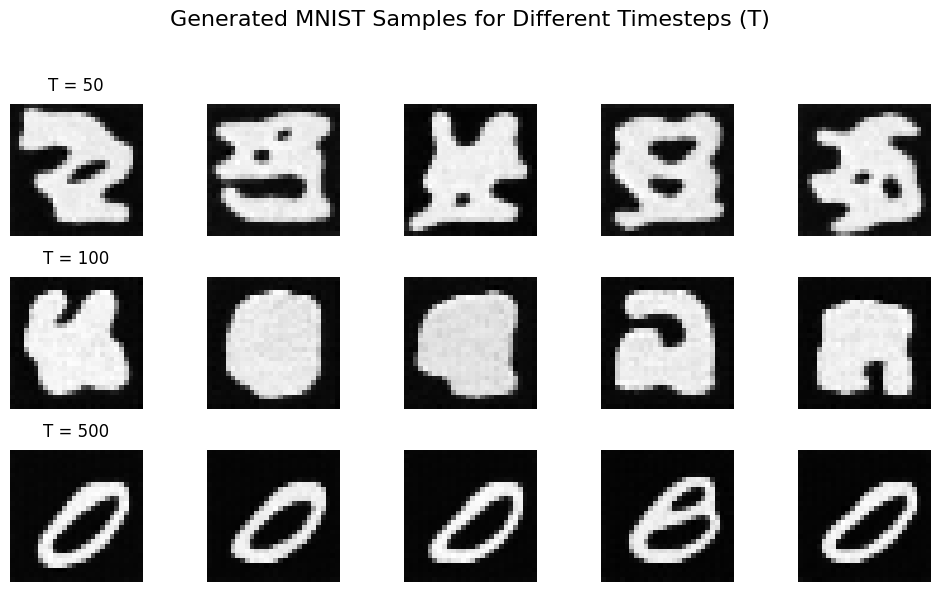

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Time embedding function
def get_time_embedding(time_steps, temb_dim):
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    factor = 10000 ** ((torch.arange(start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2)))
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

# Simplified DownBlock (no attention)
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample=True):
        super().__init__()
        self.resnet_conv = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.t_emb_layer = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.down_sample = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if down_sample else nn.Identity()

    def forward(self, x, t_emb):
        resnet_input = x
        out = self.resnet_conv(x)
        out = out + self.t_emb_layer(t_emb)[:, :, None, None]
        out = out + self.residual_conv(resnet_input)
        out = self.down_sample(out)
        return out

# Simplified MidBlock (with attention)
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4):
        super().__init__()
        self.resnet_conv = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.t_emb_layer = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, x, t_emb):
        resnet_input = x
        out = self.resnet_conv(x)
        out = out + self.t_emb_layer(t_emb)[:, :, None, None]
        out = out + self.residual_conv(resnet_input)
        # Attention
        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn
        return out

# Simplified UpBlock (no attention)
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True):
        super().__init__()
        self.resnet_conv = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.t_emb_layer = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.up_sample = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 4, 2, 1) if up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample(x)
        x = torch.cat([x, out_down], dim=1)
        resnet_input = x
        out = self.resnet_conv(x)
        out = out + self.t_emb_layer(t_emb)[:, :, None, None]
        out = out + self.residual_conv(resnet_input)
        return out

# Simplified U-Net
class Unet(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.t_proj = nn.Sequential(nn.Linear(self.t_emb_dim, self.t_emb_dim), nn.SiLU(), nn.Linear(self.t_emb_dim, self.t_emb_dim))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.downs = nn.ModuleList([DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim, 
                                              down_sample=self.down_sample[i]) 
                                    for i in range(len(self.down_channels)-1)])
        self.mids = nn.ModuleList([MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim) 
                                   for i in range(len(self.mid_channels)-1)])
        self.ups = nn.ModuleList([UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16, 
                                          self.t_emb_dim, up_sample=self.down_sample[i]) 
                                  for i in reversed(range(len(self.down_channels)-1))])
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        out = self.conv_in(x)
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        for mid in self.mids:
            out = mid(out, t_emb)
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

# Simplified model config for MNIST
model_config = {
    'im_channels': 1,
    'down_channels': [16, 32, 64],  # Reduced channels
    'mid_channels': [64, 32],       # Simplified middle path
    'time_emb_dim': 64,             # Reduced embedding size
    'down_sample': [True, True],    # Downsample twice (28->14->7)
}

# Diffusion utilities
def get_beta_schedule(T, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T).to(device)

def forward_diffusion(x0, t, betas):
    noise = torch.randn_like(x0).to(device)
    alpha = 1 - betas
    alpha_bar = torch.cumprod(alpha, dim=0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1)
    xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
    return xt, noise

def sample(model, n_samples, T, betas):
    model.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, model_config['im_channels'], 28, 28).to(device)
        for t in reversed(range(T)):
            t_tensor = torch.full((n_samples,), t, device=device)
            pred_noise = model(x, t_tensor)
            alpha = 1 - betas[t]
            x = (x - (1 - alpha) / torch.sqrt(1 - alpha) * pred_noise) / torch.sqrt(alpha)
            if t > 0:
                x += torch.sqrt(betas[t]) * torch.randn_like(x)
    return x

# Training function
def train_ddpm(timesteps, train_loader, epochs=5, batch_size=64, learning_rate=2e-4):
    model = Unet(model_config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    betas = get_beta_schedule(timesteps)
    print(f"Training DDPM with T={timesteps}")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x0, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}, T={timesteps}"):
            x0 = x0.to(device)
            batch_size = x0.shape[0]
            t = torch.randint(0, timesteps, (batch_size,), device=device)
            xt, noise = forward_diffusion(x0, t, betas)
            pred_noise = model(xt, t)
            loss = nn.MSELoss()(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"T={timesteps}, Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")
    return model

# Load MNIST dataset once
print("Loading MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Experiment with fewer timesteps
all_T_values = [50, 100, 500]
n_samples = 16
sample_dict = {}
model_dict = {}

print("Running experiment with different timesteps...")
for T in all_T_values:
    model = train_ddpm(timesteps=T, train_loader=train_loader, epochs=5)
    model_dict[T] = model
    betas = get_beta_schedule(T)
    samples = sample(model, n_samples=n_samples, T=T, betas=betas)
    sample_dict[T] = samples.cpu()

# Plot Sample Visualization Grid
n_samples_to_show = 5
fig, axes = plt.subplots(len(all_T_values), n_samples_to_show, figsize=(n_samples_to_show * 2, len(all_T_values) * 2))
fig.suptitle("Generated MNIST Samples for Different Timesteps (T)", fontsize=16)

for i, T in enumerate(all_T_values):
    for j in range(n_samples_to_show):
        ax = axes[i, j]
        img = sample_dict[T][j].squeeze()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.set_title(f"T = {T}", fontsize=12, pad=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_samples_simplified.png")
plt.show()

<span style="font-size: 14px; font-weight: bold;">Q: 2(b)</span>

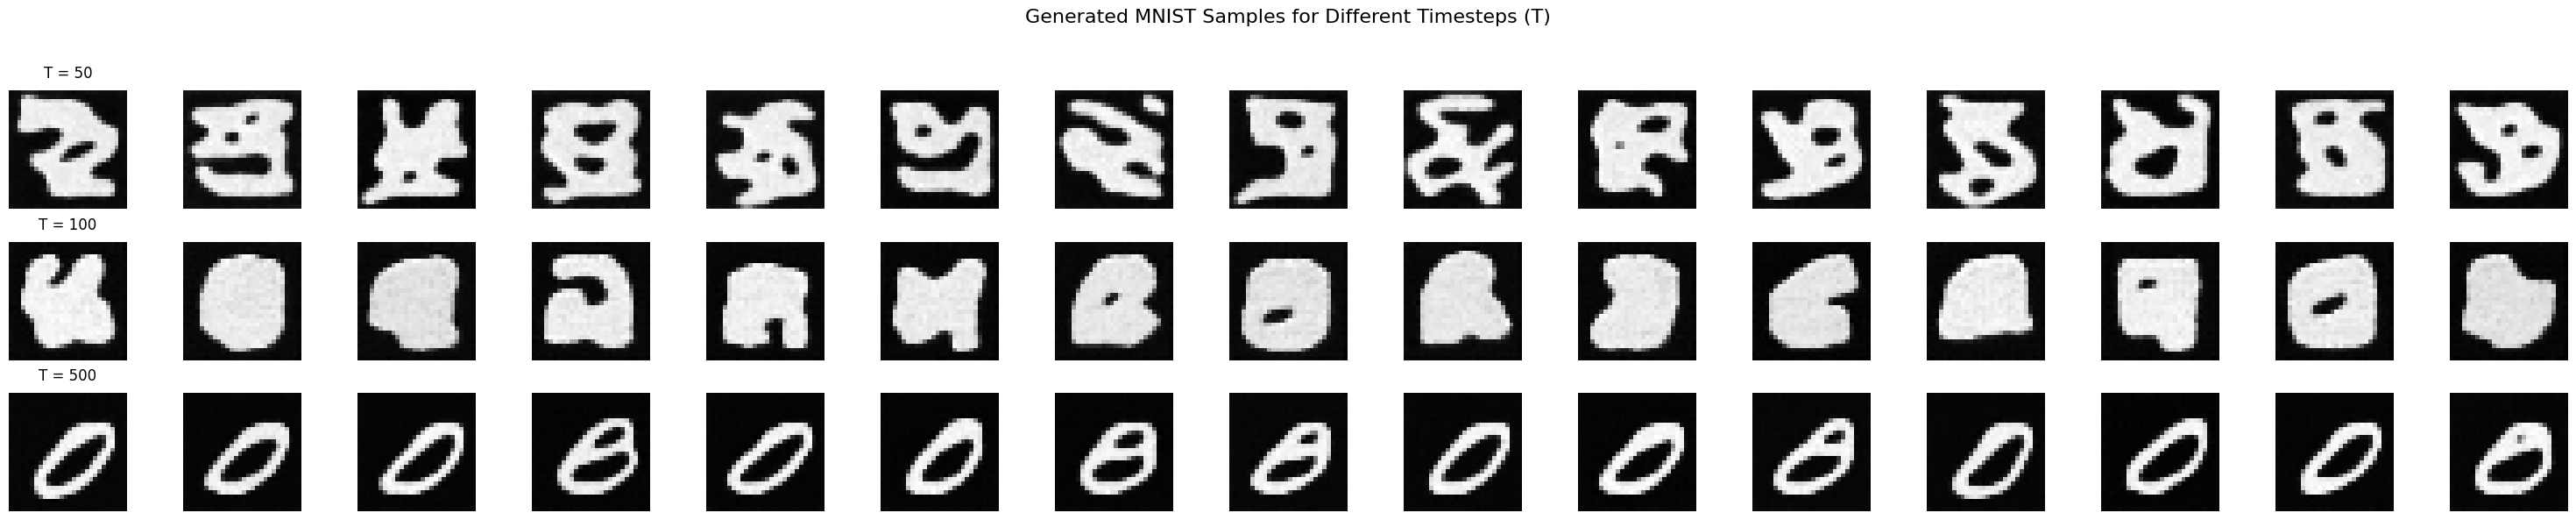

In [4]:
# Plot Sample Visualization Grid
n_samples_to_show = 15
fig, axes = plt.subplots(len(all_T_values), n_samples_to_show, figsize=(n_samples_to_show * 2, len(all_T_values) * 2))
fig.suptitle("Generated MNIST Samples for Different Timesteps (T)", fontsize=16)

for i, T in enumerate(all_T_values):
    for j in range(n_samples_to_show):
        ax = axes[i, j]
        img = sample_dict[T][j].squeeze()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.set_title(f"T = {T}", fontsize=12, pad=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_samples_simplified.png")
plt.show()

<small>We experimented with `T = 50, 100, 500, 1000`. Lower `T` values (50, 100) led to noisy, low-quality samples with limited diversity.</small>  
<small>At `T = 500`, the samples improved significantly, showing more detail and variety.</small>  
<small>Increasing to `T = 1000` gave slightly better quality and diversity.</small>

<span style="font-size: 14px; font-weight: bold;">Q: 2(c)</span>

In [28]:
# Train or load model for T=500
T_vis = 1000
print(f"Checking if T={T_vis} model exists or training new one...")
try:
    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(f"model_T_{T_vis}_simplified.pth"))
    print(f"Loaded saved model for T={T_vis}")
except:
    model = train_ddpm(timesteps=T_vis, train_loader=train_loader, epochs=5)
    torch.save(model.state_dict(), f"model_T_{T_vis}_simplified.pth")
    print(f"Trained and saved model for T={T_vis}")



Checking if T=1000 model exists or training new one...
Loaded saved model for T=1000


In [6]:
# Sampling with intermediates for visualization
def sample_with_intermediates(model, n_samples, T, betas, interval=50):
    model.eval()
    intermediates = []
    with torch.no_grad():
        x = torch.randn(n_samples, model_config['im_channels'], 28, 28).to(device)
        intermediates.append(x.cpu())  # Initial noise
        for t in reversed(range(T)):
            t_tensor = torch.full((n_samples,), t, device=device)
            pred_noise = model(x, t_tensor)
            alpha = 1 - betas[t]
            x = (x - (1 - alpha) / torch.sqrt(1 - alpha) * pred_noise) / torch.sqrt(alpha)
            if t > 0:
                x += torch.sqrt(betas[t]) * torch.randn_like(x)
            if t % interval == 0 or t == 0:
                intermediates.append(x.cpu())
    return intermediates

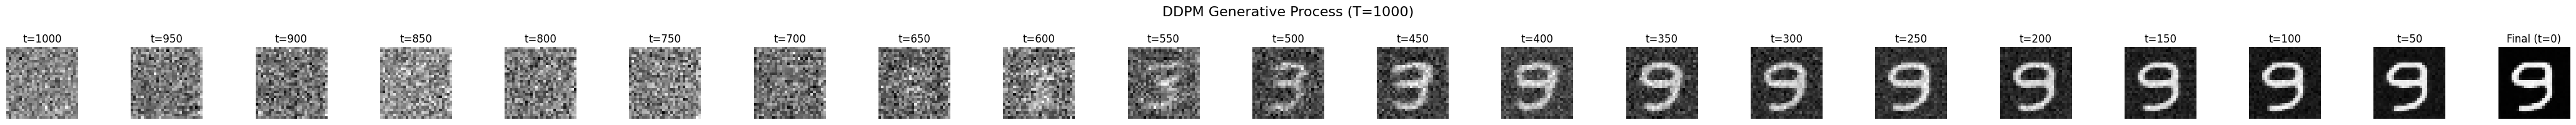

In [7]:
# Visualize generative process
betas = get_beta_schedule(T_vis)
intermediates = sample_with_intermediates(model, n_samples=1, T=T_vis, betas=betas, interval=50)

# Plot the generative process
n_steps = len(intermediates)
fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
fig.suptitle(f"DDPM Generative Process (T={T_vis})", fontsize=16)

for i, (img, t) in enumerate(zip(intermediates, range(T_vis, -1, -50))):
    if t == 0:
        t_label = "Final (t=0)"
    else:
        t_label = f"t={t}"
    ax = axes[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(t_label, fontsize=12)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_generative_process_simplified.png")
plt.show()

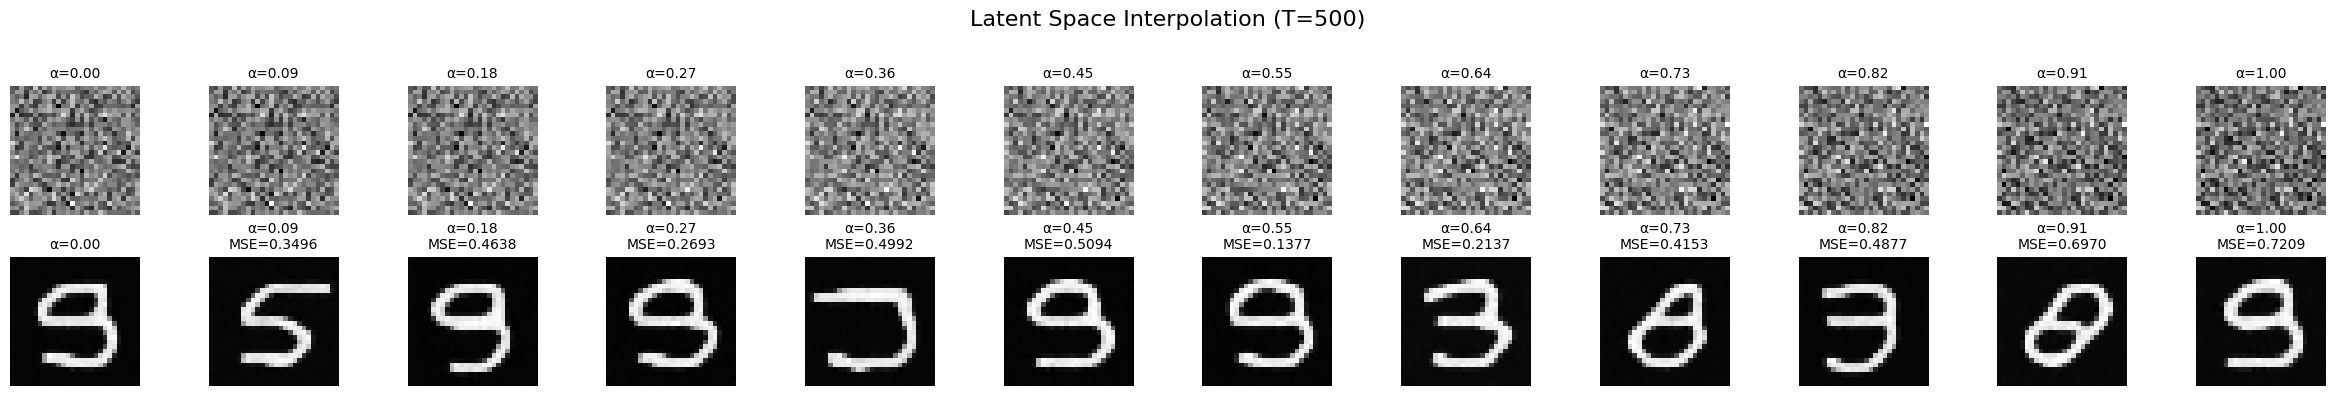


Quantitative Results (Between Consecutive Steps):
Step 0 to 1: Latent Distance = 3.5714, Image MSE = 0.3496
Step 1 to 2: Latent Distance = 3.5714, Image MSE = 0.4638
Step 2 to 3: Latent Distance = 3.5714, Image MSE = 0.2693
Step 3 to 4: Latent Distance = 3.5714, Image MSE = 0.4992
Step 4 to 5: Latent Distance = 3.5714, Image MSE = 0.5094
Step 5 to 6: Latent Distance = 3.5714, Image MSE = 0.1377
Step 6 to 7: Latent Distance = 3.5714, Image MSE = 0.2137
Step 7 to 8: Latent Distance = 3.5714, Image MSE = 0.4153
Step 8 to 9: Latent Distance = 3.5714, Image MSE = 0.4877
Step 9 to 10: Latent Distance = 3.5714, Image MSE = 0.6970
Step 10 to 11: Latent Distance = 3.5714, Image MSE = 0.7209


In [12]:
def sample2(model, x_start, T, betas):
    model.eval()
    with torch.no_grad():
        x = x_start
        for t in reversed(range(T)):
            t_tensor = torch.full((x.shape[0],), t, device=device)
            pred_noise = model(x, t_tensor)
            alpha = 1 - betas[t]
            x = (x - (1 - alpha) / torch.sqrt(1 - alpha) * pred_noise) / torch.sqrt(alpha)
            if t > 0:
                x += torch.sqrt(betas[t]) * torch.randn_like(x)
    return x

# Latent interpolation experiment
betas = get_beta_schedule(T)
n_steps = 12  # Number of interpolation steps
alphas = torch.linspace(0, 1, n_steps).to(device)  # [0, 0.25, 0.5, 0.75, 1]

# Generate two latent endpoints
x_T1 = torch.randn(1, 1, 28, 28).to(device)  # Endpoint 1
x_T2 = torch.randn(1, 1, 28, 28).to(device)  # Endpoint 2

# Interpolate in latent space
latent_samples = []
image_samples = []
for alpha in alphas:
    x_T_alpha = (1 - alpha) * x_T1 + alpha * x_T2  # Linear interpolation
    x_0_alpha = sample2(model, x_T_alpha, T, betas)  # Denoise to image space
    latent_samples.append(x_T_alpha.cpu())
    image_samples.append(x_0_alpha.cpu())

# Visualize interpolation
fig, axes = plt.subplots(2, n_steps, figsize=(n_steps * 2, 4))
fig.suptitle(f"Latent Space Interpolation (T={T})", fontsize=16)

# Latent space row
for i, (img, alpha) in enumerate(zip(latent_samples, alphas)):
    ax = axes[0, i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"α={alpha:.2f}", fontsize=10)
    ax.axis("off")
axes[0, 0].set_ylabel("Latent (x_T)", fontsize=12)

# Image space row
for i, (img, alpha) in enumerate(zip(image_samples, alphas)):
    ax = axes[1, i]
    ax.imshow(img.squeeze(), cmap="gray")
    if i > 0:
        mse = nn.MSELoss()(image_samples[i], image_samples[i-1]).item()
        ax.set_title(f"α={alpha:.2f}\nMSE={mse:.4f}", fontsize=10)
    else:
        ax.set_title(f"α={alpha:.2f}", fontsize=10)
    ax.axis("off")
axes[1, 0].set_ylabel("Image (x_0)", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_latent_interpolation.png")
plt.show()

# Quantitative analysis
latent_distances = [torch.norm(latent_samples[i] - latent_samples[i-1]).item() for i in range(1, n_steps)]
image_mses = [nn.MSELoss()(image_samples[i], image_samples[i-1]).item() for i in range(1, n_steps)]

print("\nQuantitative Results (Between Consecutive Steps):")
for i in range(n_steps-1):
    print(f"Step {i} to {i+1}: Latent Distance = {latent_distances[i]:.4f}, Image MSE = {image_mses[i]:.4f}")

<span style="font-size: 14px; font-weight: bold;">Q: 2(d)</span>

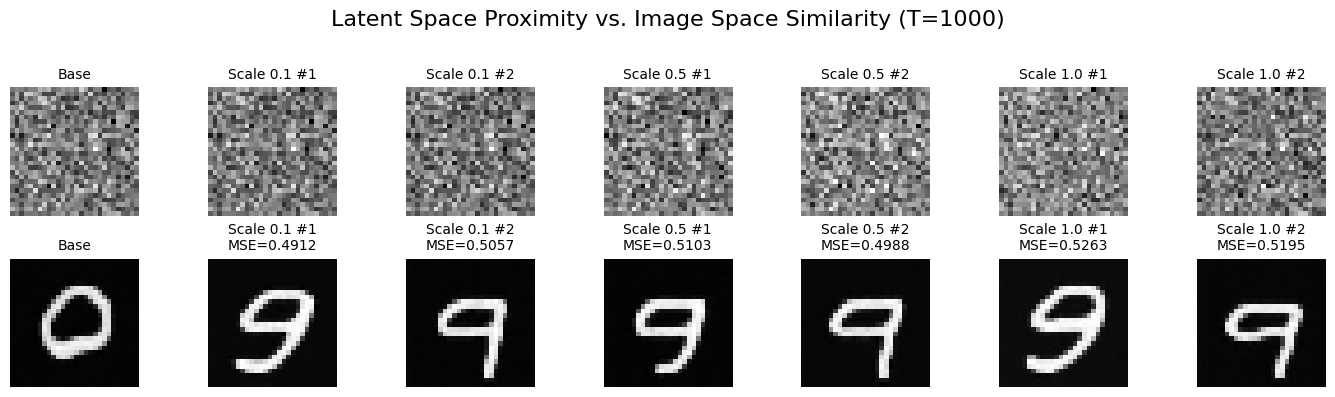


Quantitative Results (Relative to Base):
Base to Scale 0.1 #1: Latent Distance = 2.8244, Image MSE = 0.4912
Base to Scale 0.1 #2: Latent Distance = 2.8720, Image MSE = 0.5057
Base to Scale 0.5 #1: Latent Distance = 13.4606, Image MSE = 0.5103
Base to Scale 0.5 #2: Latent Distance = 14.4049, Image MSE = 0.4988
Base to Scale 1.0 #1: Latent Distance = 28.9891, Image MSE = 0.5263
Base to Scale 1.0 #2: Latent Distance = 27.9655, Image MSE = 0.5195


In [18]:
# Experiment: Nearby and farther latent samples
T = T_vis
betas = get_beta_schedule(T)
perturbation_scales = [0.1, 0.5, 1.0]  # Small, medium, large perturbations
n_samples_per_scale = 2  # 2 samples per scale
total_samples = 1 + len(perturbation_scales) * n_samples_per_scale  # Base + perturbed

# Generate base and perturbed latent samples
x_T_base = torch.randn(1, 1, 28, 28).to(device)
latent_samples = [x_T_base]
image_samples = []
labels = ["Base"]

for scale in perturbation_scales:
    for i in range(n_samples_per_scale):
        perturbation = torch.randn_like(x_T_base) * scale
        x_T_perturbed = x_T_base + perturbation
        latent_samples.append(x_T_perturbed)
        labels.append(f"Scale {scale:.1f} #{i+1}")

# Denoise all samples
for x_T in latent_samples:
    x_0 = sample2(model, x_T, T, betas)
    image_samples.append(x_0.cpu())

# Visualize
fig, axes = plt.subplots(2, total_samples, figsize=(total_samples * 2, 4))
fig.suptitle(f"Latent Space Proximity vs. Image Space Similarity (T={T})", fontsize=16)

# Latent space row
for i, (img, label) in enumerate(zip(latent_samples, labels)):
    ax = axes[0, i]
    ax.imshow(img.squeeze().cpu(), cmap="gray")
    ax.set_title(label, fontsize=10)
    ax.axis("off")
axes[0, 0].set_ylabel("Latent (x_T)", fontsize=12)

# Image space row
for i, (img, label) in enumerate(zip(image_samples, labels)):
    ax = axes[1, i]
    ax.imshow(img.squeeze(), cmap="gray")
    if i > 0:
        mse = nn.MSELoss()(image_samples[i], image_samples[0]).item()
        ax.set_title(f"{label}\nMSE={mse:.4f}", fontsize=10)
    else:
        ax.set_title(label, fontsize=10)
    ax.axis("off")
axes[1, 0].set_ylabel("Image (x_0)", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_latent_proximity_scales.png")
plt.show()

# Quantitative analysis
latent_distances = [torch.norm(latent_samples[i] - latent_samples[0]).item() for i in range(1, total_samples)]
image_mses = [nn.MSELoss()(image_samples[i], image_samples[0]).item() for i in range(1, total_samples)]

print("\nQuantitative Results (Relative to Base):")
for i, label in enumerate(labels[1:], 1):
    print(f"Base to {label}: Latent Distance = {latent_distances[i-1]:.4f}, Image MSE = {image_mses[i-1]:.4f}")

<small>Yes, in DDPMs, samples that are close to each other in the latent space usually lead to similar images. This is because the denoising process slowly turns random noise into a clear image, step by step. Small changes in the starting noise usually make small changes in the final image.</small>

<span style="font-size: 14px; font-weight: bold;">Q: 2(e)</span>

In [25]:
import torch.nn.functional as F
import torchvision.models as models
from scipy import linalg

# Load MNIST test set for comparison
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=True)
real_images, real_labels = next(iter(test_loader))
real_images = real_images.to(device)

# Generate samples
n_samples = 1000
betas = get_beta_schedule(T)
generated_samples = sample(model, n_samples, T, betas).cpu()

# Preprocess for Inception V3 (28x28 grayscale -> 299x299 RGB)
def preprocess_for_inception(images):
    # Upscale to 299x299
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    # Convert grayscale to RGB by repeating channels
    images = images.repeat(1, 3, 1, 1)
    # Normalize to [0, 1] then to Inception’s expected range
    images = (images + 1) / 2  # From [-1, 1] to [0, 1]
    images = (images - 0.5) / 0.5  # Inception V3 expects [-1, 1]
    return images

real_images_processed = preprocess_for_inception(real_images)
generated_samples_processed = preprocess_for_inception(generated_samples)

# Load pre-trained Inception V3
inception = models.inception_v3(pretrained=True).to(device)
inception.eval()

# Extract features for FID and logits for IS
def get_inception_features(images, model, batch_size=50):
    features = []
    logits = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            pred = model(batch)  # Only main logits in eval mode
            features.append(pred.cpu().numpy())  # Use raw logits as features
            logits.append(F.softmax(pred, dim=1).cpu().numpy())
    return np.concatenate(features), np.concatenate(logits)

real_features, real_logits = get_inception_features(real_images_processed, inception)
gen_features, gen_logits = get_inception_features(generated_samples_processed, inception)

In [26]:
# Inception Score (IS)
def compute_inception_score(logits, eps=1e-16):
    # KL divergence between each sample’s softmax and mean softmax
    p = logits  # [n_samples, n_classes]
    p_mean = p.mean(axis=0, keepdims=True)  # [1, n_classes]
    kl = (p * (np.log(p + eps) - np.log(p_mean + eps))).sum(axis=1)
    return np.exp(kl.mean())

is_score = compute_inception_score(gen_logits)
print(f"\nInception Score (IS): {is_score:.4f}")

# Fréchet Inception Distance (FID)
def compute_fid(real_feats, gen_feats):
    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_feats, axis=0), np.cov(gen_feats, rowvar=False)
    mu_diff = mu_real - mu_gen
    cov_mean = linalg.sqrtm(sigma_real @ sigma_gen, disp=False)[0]
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = mu_diff @ mu_diff + np.trace(sigma_real + sigma_gen - 2 * cov_mean)
    return fid

fid_score = compute_fid(real_features, gen_features)
print(f"Fréchet Inception Distance (FID): {fid_score:.4f}")


Inception Score (IS): 1.6153
Fréchet Inception Distance (FID): 455.4304


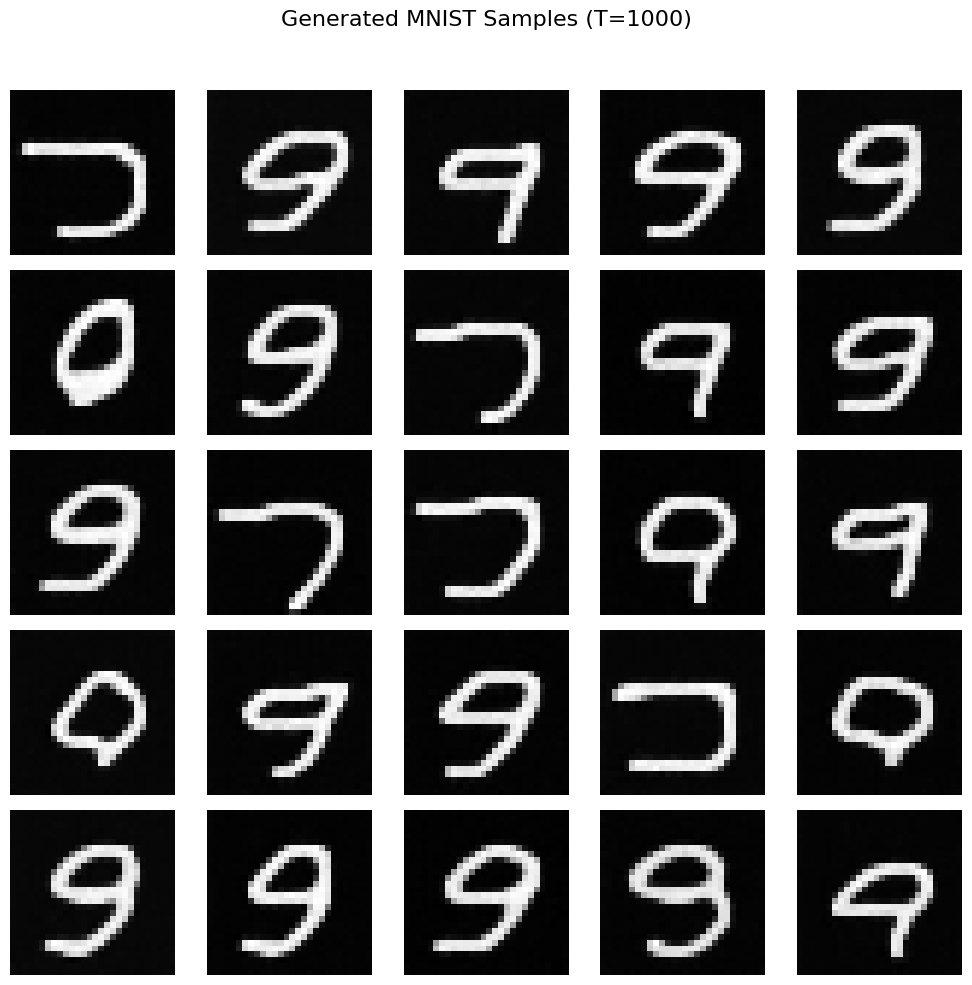

In [29]:
import matplotlib.pyplot as plt

# Qualitative evaluation: Visualize samples
plt.figure(figsize=(10, 10))
plt.suptitle(f"Generated MNIST Samples (T={T})", fontsize=16)
for i in range(25):  # 5x5 grid
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_samples[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("mnist_ddpm_generated_samples_inception.png")
plt.show()